In [4]:
from statsbombpy import sb
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import seaborn as sns
from causalimpact import CausalImpact

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Request competition info
competitions = sb.competitions()

In [6]:
competitions[competitions['competition_gender'] == 'female']

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
22,37,90,England,FA Women's Super League,female,False,False,2020/2021,2023-02-25T14:52:09.326729,2021-06-13T16:17:31.694,None,2023-02-25T14:52:09.326729
23,37,42,England,FA Women's Super League,female,False,False,2019/2020,2023-07-25T01:08:03.214566,2021-06-13T16:17:31.694,None,2023-07-25T01:08:03.214566
24,37,4,England,FA Women's Super League,female,False,False,2018/2019,2023-07-24T19:50:20.881595,2021-06-13T16:17:31.694,None,2023-07-24T19:50:20.881595
57,49,3,United States of America,NWSL,female,False,False,2018,2023-07-24T13:01:22.094587,2021-06-13T16:17:31.694,None,2023-07-24T13:01:22.094587
64,53,106,Europe,UEFA Women's Euro,female,False,True,2022,2023-07-17T21:19:03.032991,2023-07-17T21:21:56.497106,2023-07-17T21:21:56.497106,2023-07-17T21:19:03.032991
65,72,107,International,Women's World Cup,female,False,True,2023,2023-09-01T12:34:19.705316,2023-09-01T12:35:45.762196,2023-09-01T12:35:45.762196,2023-09-01T12:34:19.705316
66,72,30,International,Women's World Cup,female,False,True,2019,2023-07-27T10:33:48.273734,2021-06-13T16:17:31.694,None,2023-07-27T10:33:48.273734


In [6]:
def load_json(url):
    '''
    Load json data from the given URL.
    '''
    response = requests.get(url)
    return response.json()

In [7]:
def get_event(match_id):
    url = f'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json'
    js = js = load_json(url)
    return js

In [8]:
# Request match data for WSL 2022 season
url_WSL_2022 = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/37/90.json'
WSL_2022 = load_json(url_WSL_2022)

In [9]:
# Generate team name tuples
team_dict = {m['match_id']:(m['home_team']['home_team_name'], m['away_team']['away_team_name'])
            for m in WSL_2022}

In [10]:
# Generate list of match ids
match_list = [str(match['match_id']) for match in WSL_2022]

In [10]:
len(match_list)

131

In [11]:
# Generate list of manager names
home_manager = [m['home_team']['managers'][0]['name'] for m in WSL_2022]
away_manager = [m['away_team']['managers'][0]['name'] for m in WSL_2022]

manager_list = list(set(home_manager + away_manager))

In [13]:
# Generate manager and team pairs to check overlapping
manager_team_dict = {}

In [14]:
for manager in manager_list:
    t_h = [m['home_team']['home_team_name'] for m in WSL_2022 if m['home_team']['managers'][0]['name'] == manager]
    t_a = [m['away_team']['away_team_name'] for m in WSL_2022 if m['away_team']['managers'][0]['name'] == manager]
    manager_team_dict[manager] =list(set(t_h + t_a))

In [39]:
manager_team_dict

{'Karen Hills': ['Tottenham Hotspur Women'],
 'Joseph Montemurro': ['Arsenal WFC'],
 'Willie Kirk': ['Everton LFC'],
 'Tanya Oxtoby': ['Bristol City WFC'],
 'Gemma Davies': ['Aston Villa'],
 'Olli Harder': ['West Ham United LFC'],
 'Marcus Bignot': ['Aston Villa'],
 'Kelly Chambers': ['Reading WFC'],
 'Billy Stewart': ['West Ham United LFC'],
 'Gareth Taylor': ['Manchester City WFC'],
 'Matt Beard': ['West Ham United LFC', 'Bristol City WFC'],
 'Carla Ward': ['Birmingham City WFC'],
 'Hope Patricia Powell': ['Brighton & Hove Albion WFC'],
 'Casey Stoney': ['Manchester United'],
 'Rehanne Skinner': ['Tottenham Hotspur Women'],
 'Emma Hayes': ['Chelsea FCW']}

In [15]:
# Generate list of match ids every coach coached in the season
manager_match_dict = {}

In [16]:
for manager in manager_list:
    manager_match_dict[manager] = [m['match_id'] for m in WSL_2022 if m['home_team']['managers'][0]['name'] == manager
                            or m['away_team']['managers'][0]['name'] == manager]

In [17]:
def get_xg(match_id, team):
    '''
    Generate dataframe containing time and xg info for selected match and selected team
    
    Arg: match_id(int)
         team(str)
    Return: dataframe
    '''
    events = get_event(match_id)
    events_team = [e for e in events if e['team']['name'] == team]
    
    shots = [e for e in events_team if e['type']['id'] == 16]
    xg = [{'minute':e['minute'], 'second':e['second'], 'xg':e['shot']['statsbomb_xg'], 
           'outcome':e['shot']['outcome']['name']} for e in shots]
    
    xg_df = pd.DataFrame(xg)
    xg_df['total_seconds'] = xg_df.apply(lambda row: row['minute']*60 + row['second'], axis = 1)
    xg_df['outcome'] = xg_df['outcome'].apply(lambda x: x if x == 'Goal' else 'No Goal')
    
    return xg_df

In [18]:
def get_sub(match_id, team):
    '''
    Generate a list of subsitition time for selected match and selected team
    
    Arg: match_id(int)
         team(str)
    Return: list
    '''
    events = get_event(match_id)
    events_team = [e for e in events if e['team']['name'] == team]
    
    substitions = [e for e in events_team if e['type']['id'] == 19]
    sub_time = [e['minute']*60 + e['second'] for e in substitions]
       
    return sub_time

In [51]:
len(manager_match_dict['Karen Hills'])

7

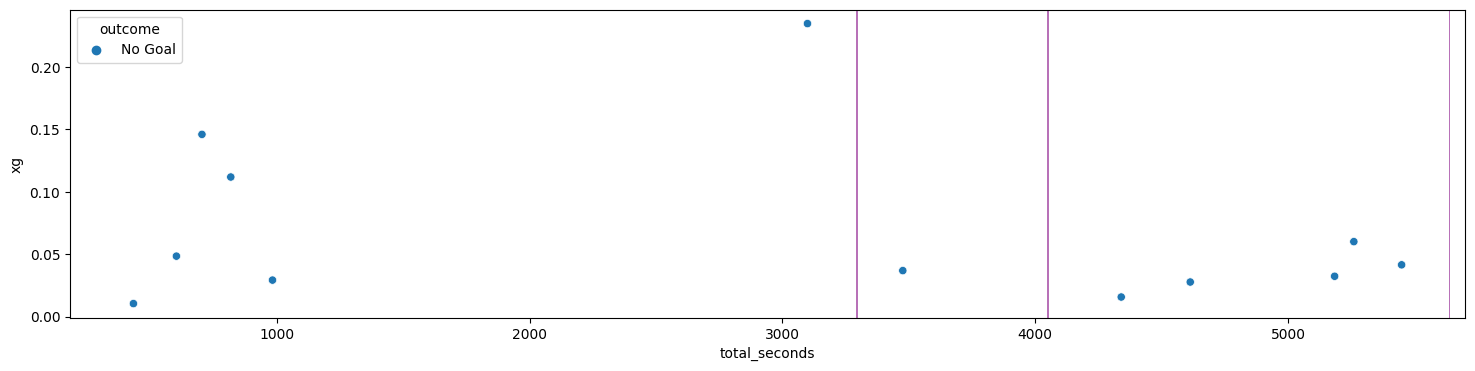

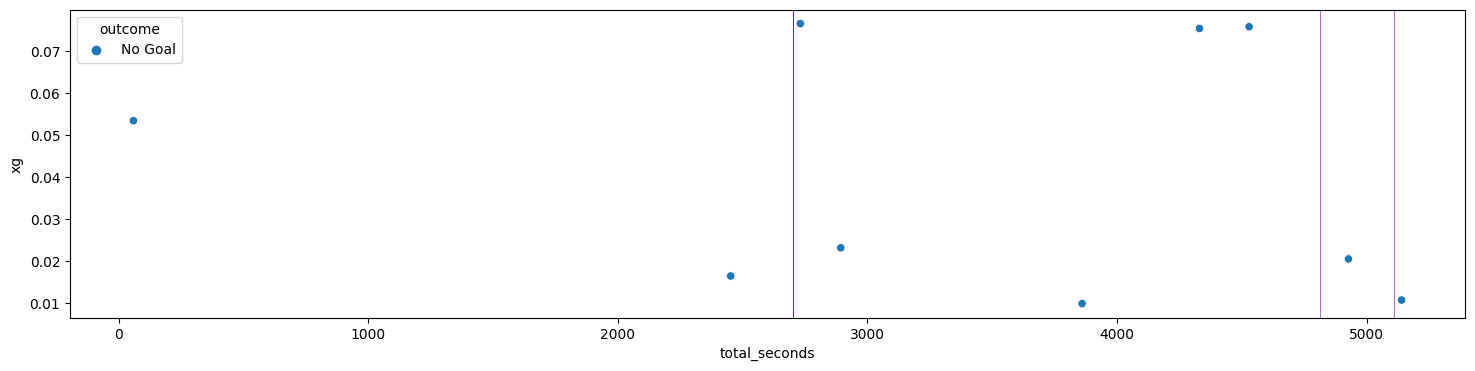

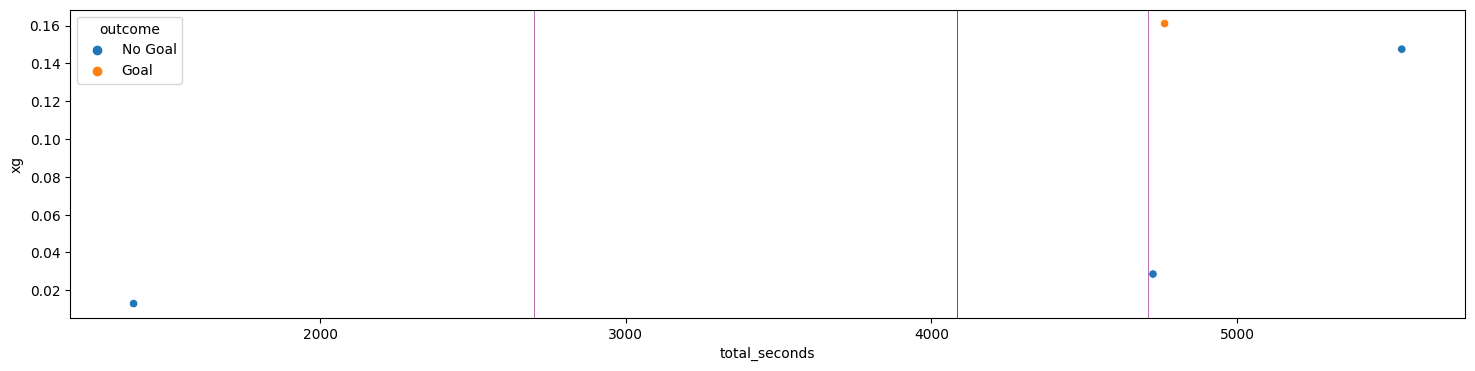

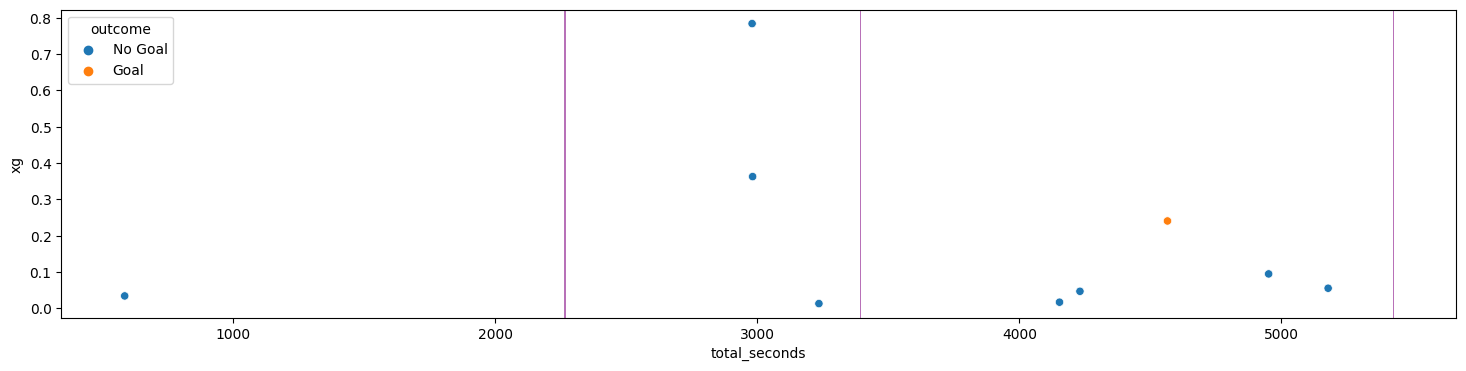

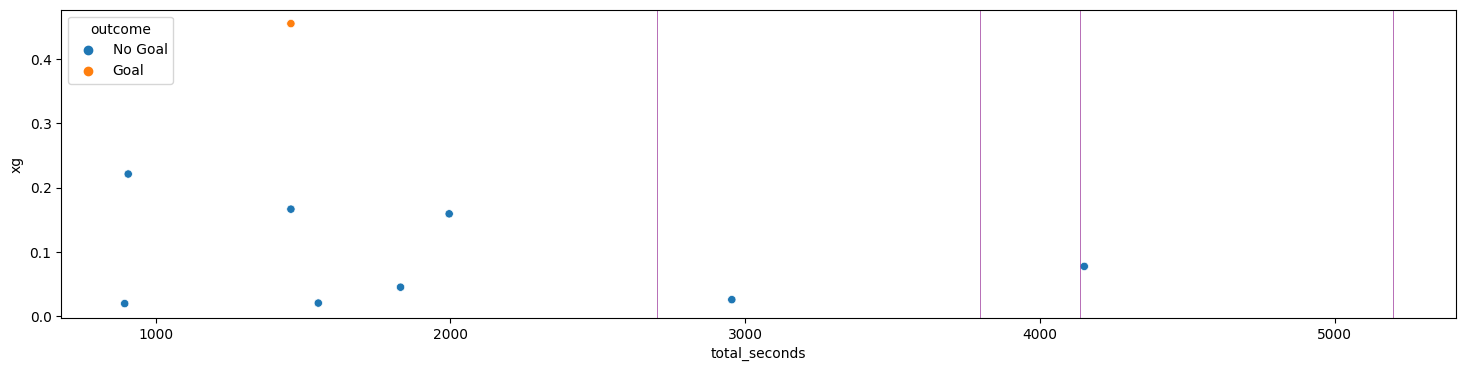

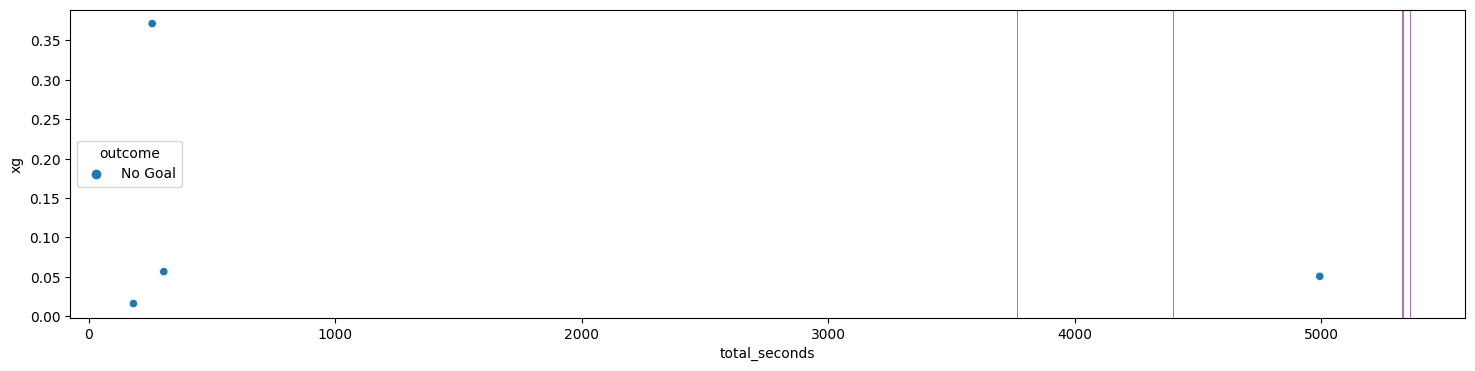

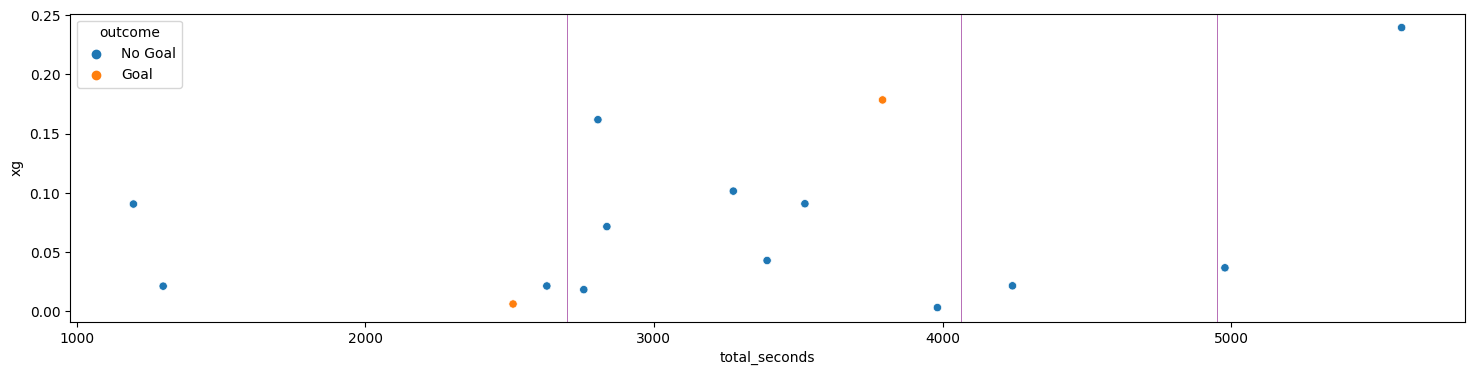

In [19]:
# Plot xg by time (seconds) and mark substitution for all matches Karen Hills coached
for match in manager_match_dict['Karen Hills']:
    plt.subplots(figsize=(18,4))
    xg_df = get_xg(match, 'Tottenham Hotspur Women')
    sub_time= get_sub(match, 'Tottenham Hotspur Women')
    sns.scatterplot(data = xg_df, x = 'total_seconds', y = 'xg', hue = 'outcome')
    for t in sub_time:
        plt.axvline(x = t, color = 'purple', linewidth=0.4)

In [53]:
len(manager_match_dict['Gareth Taylor'])

22

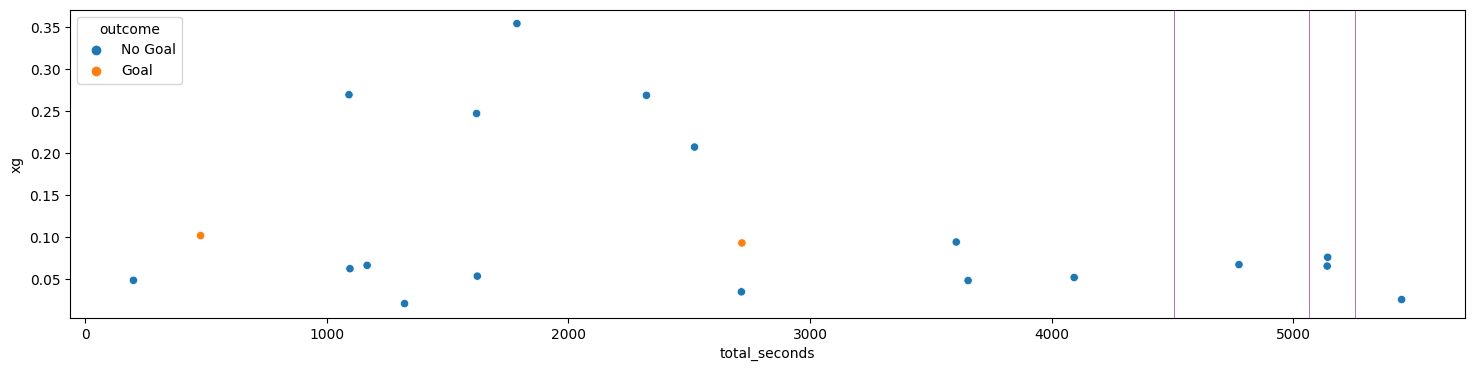

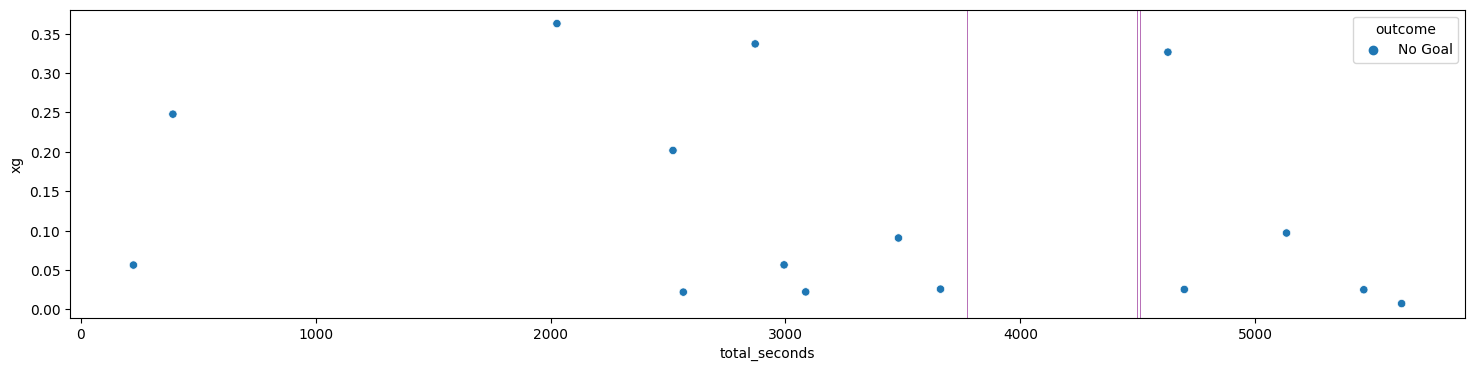

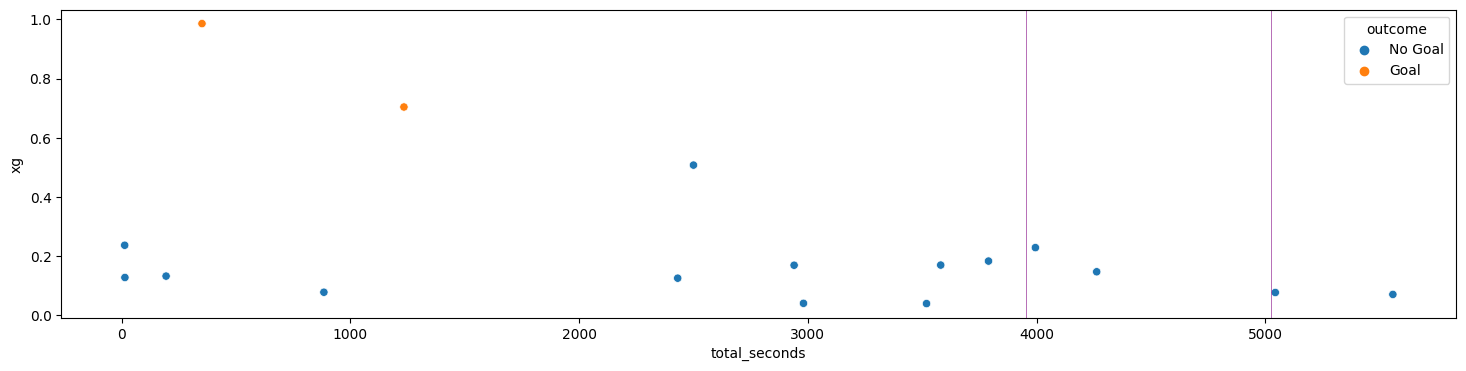

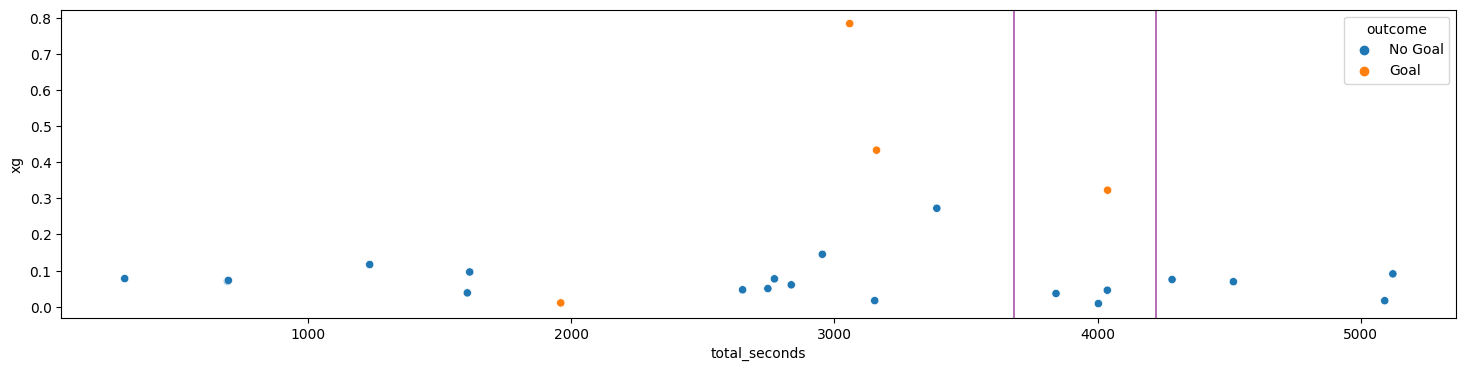

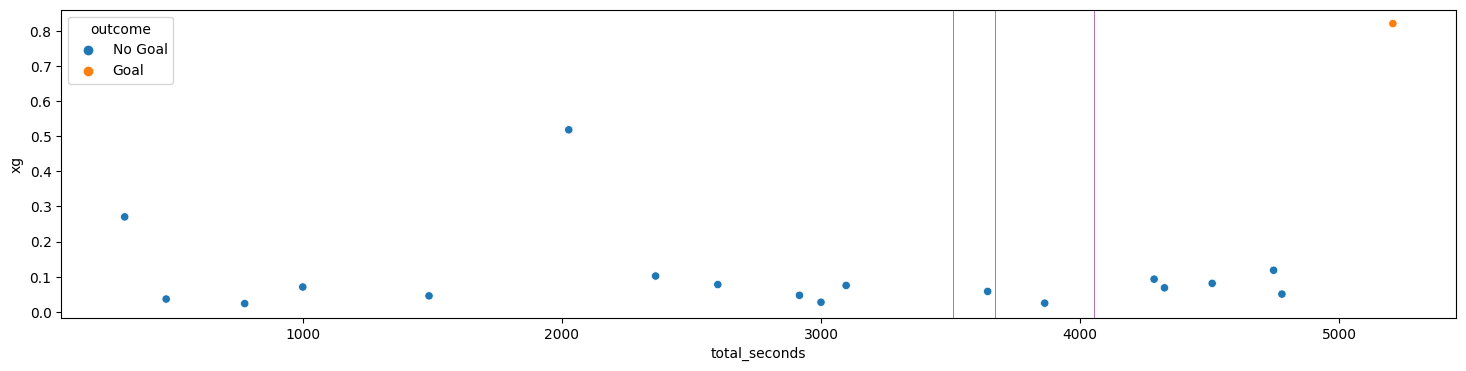

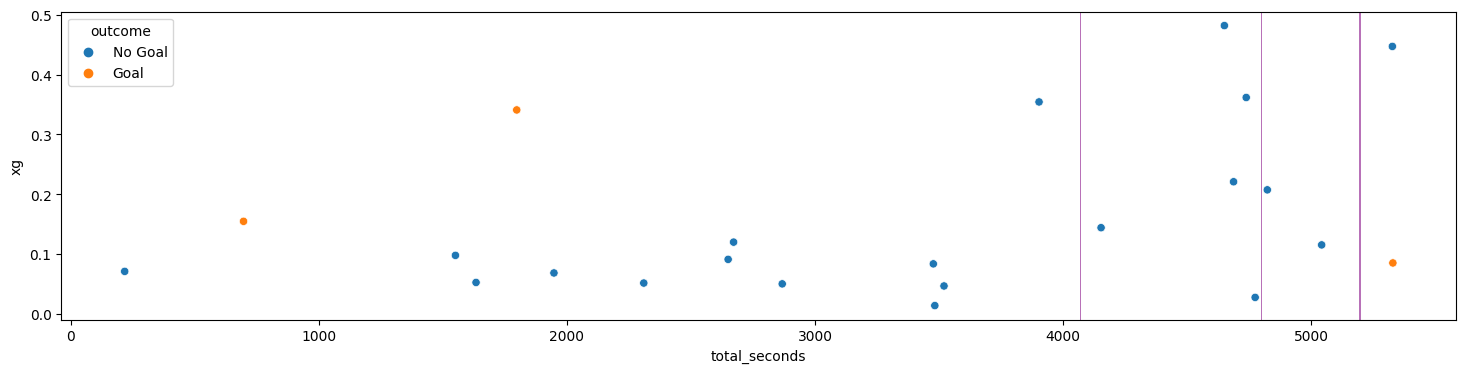

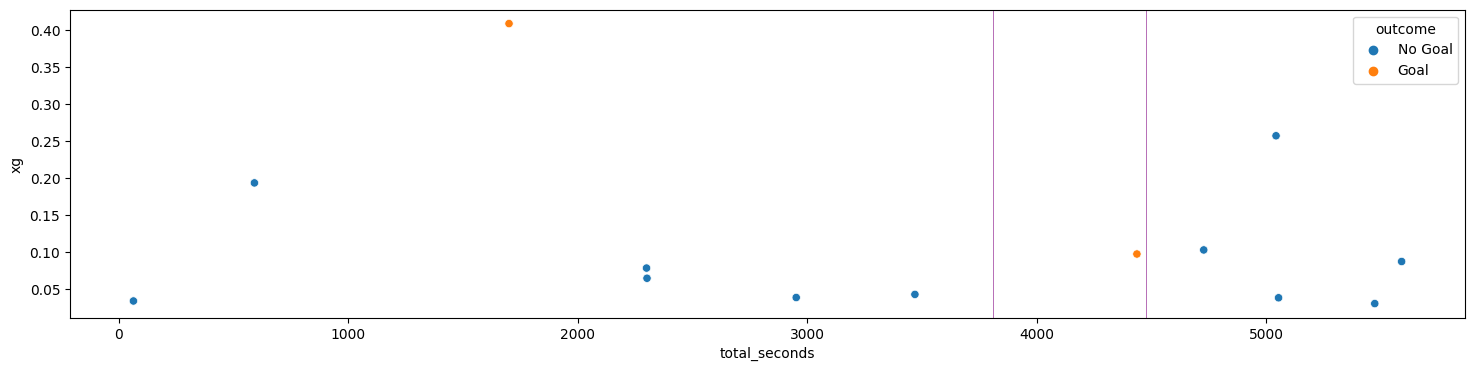

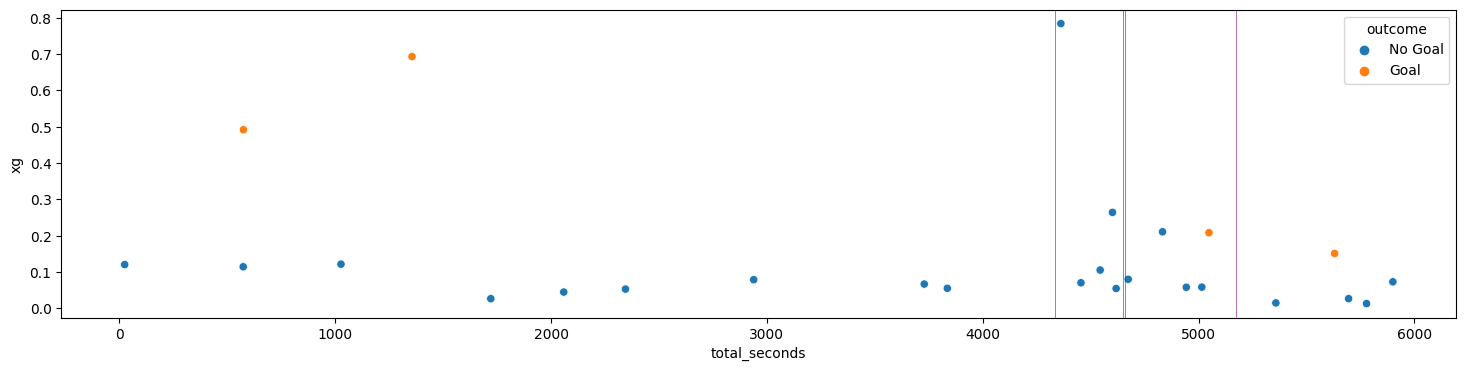

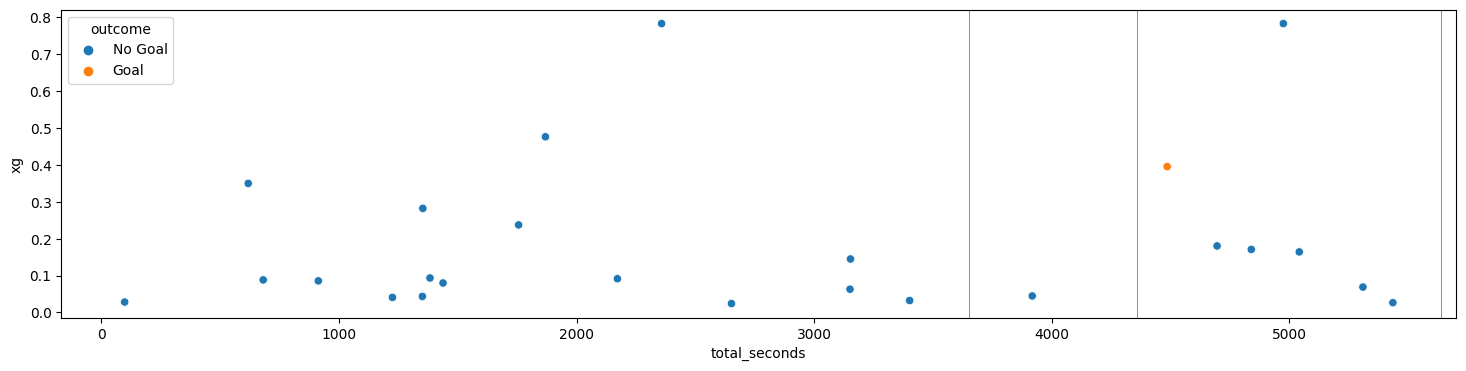

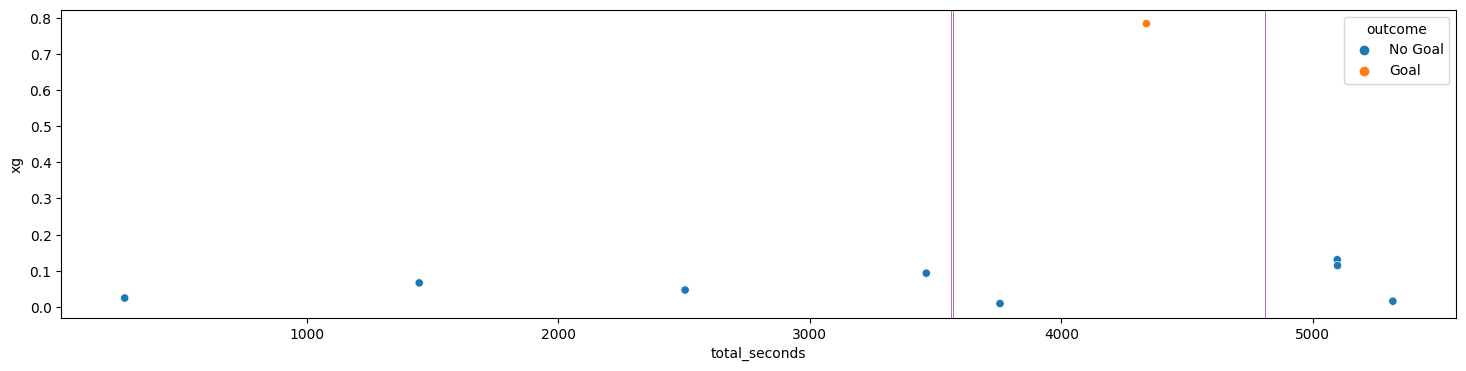

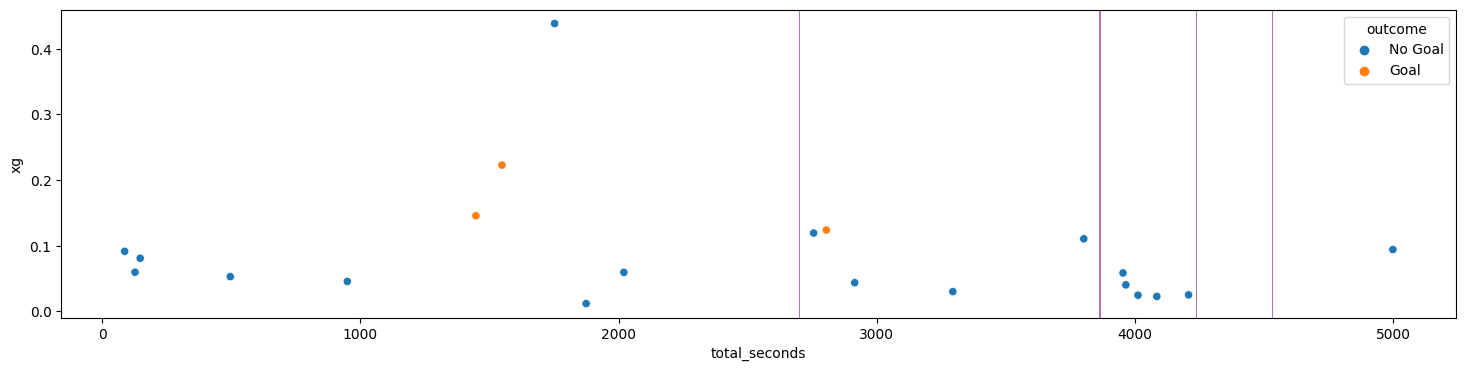

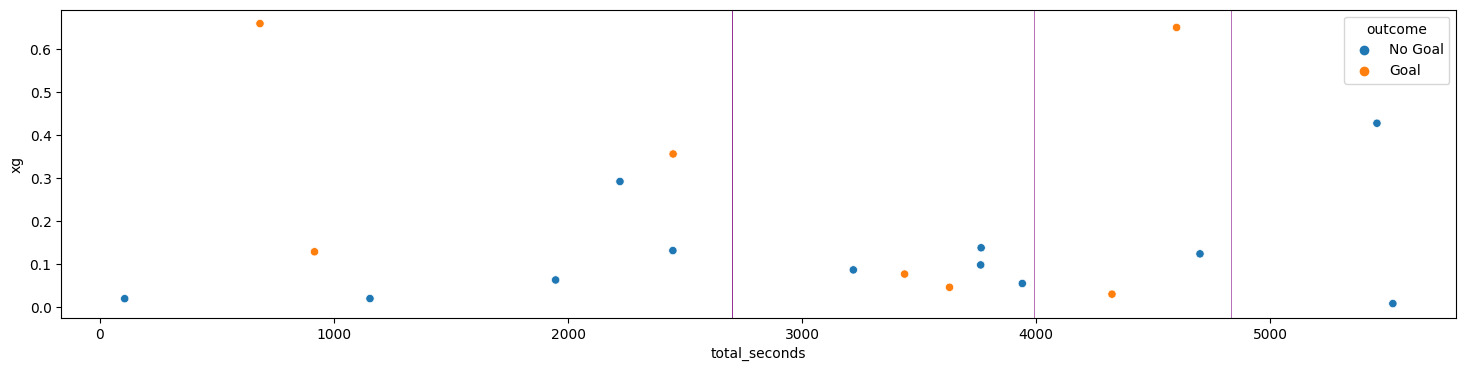

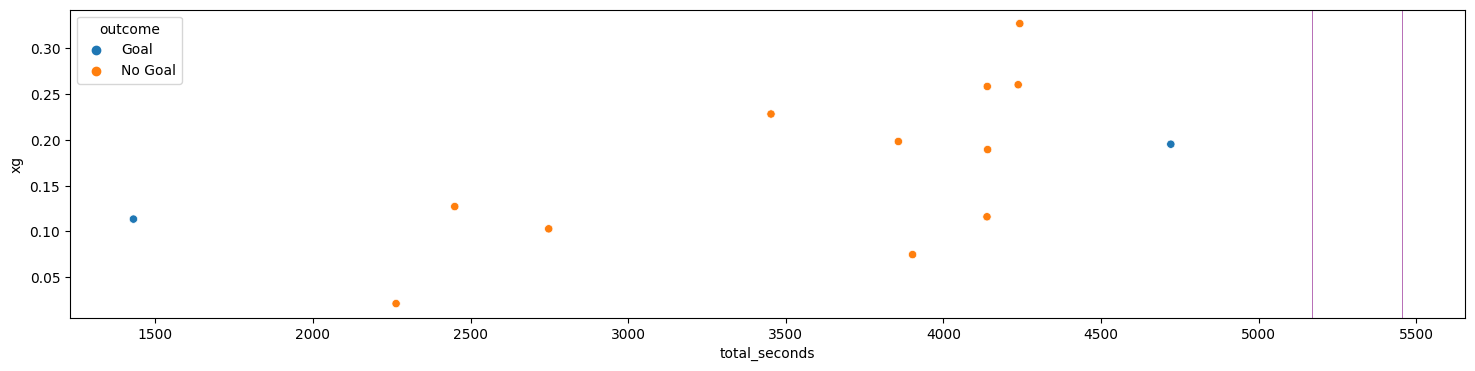

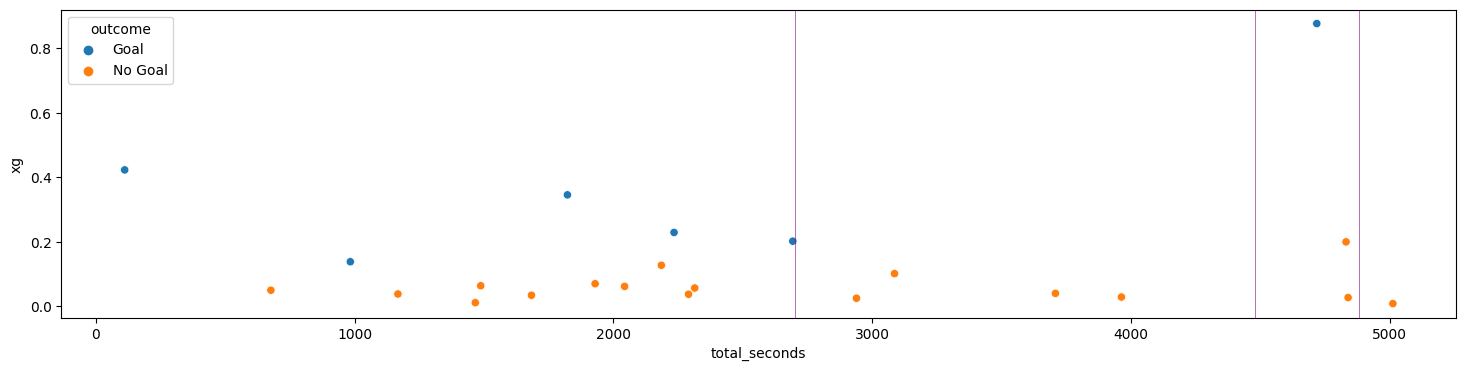

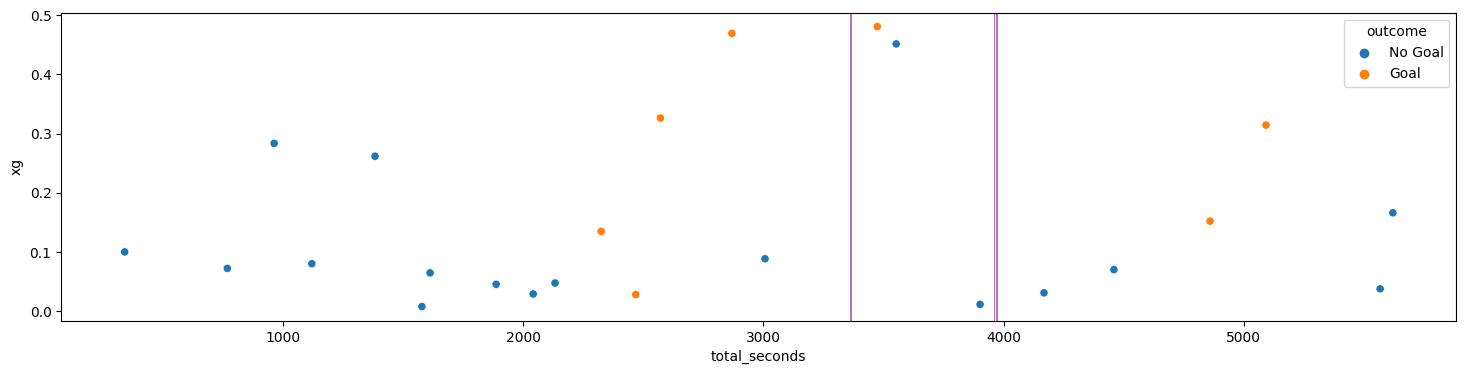

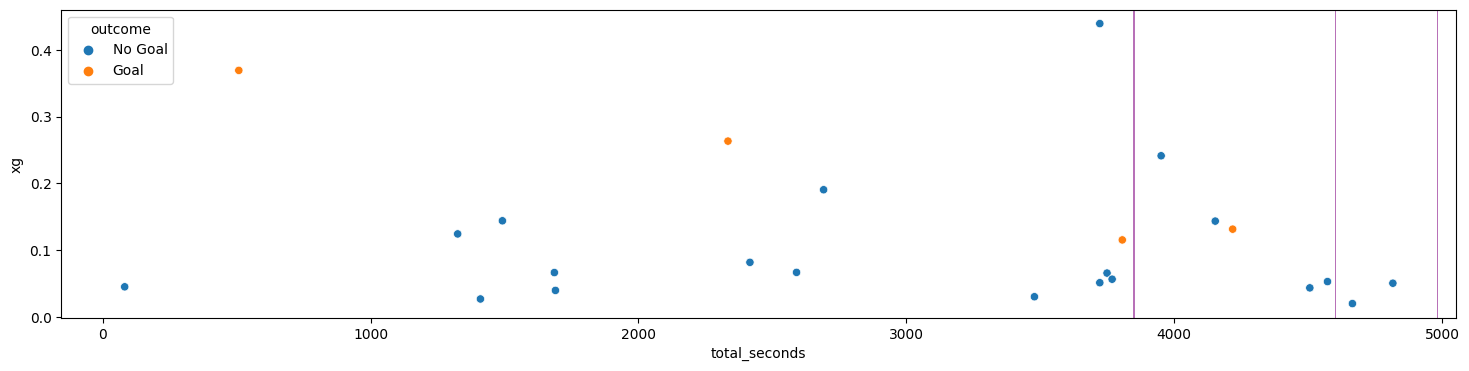

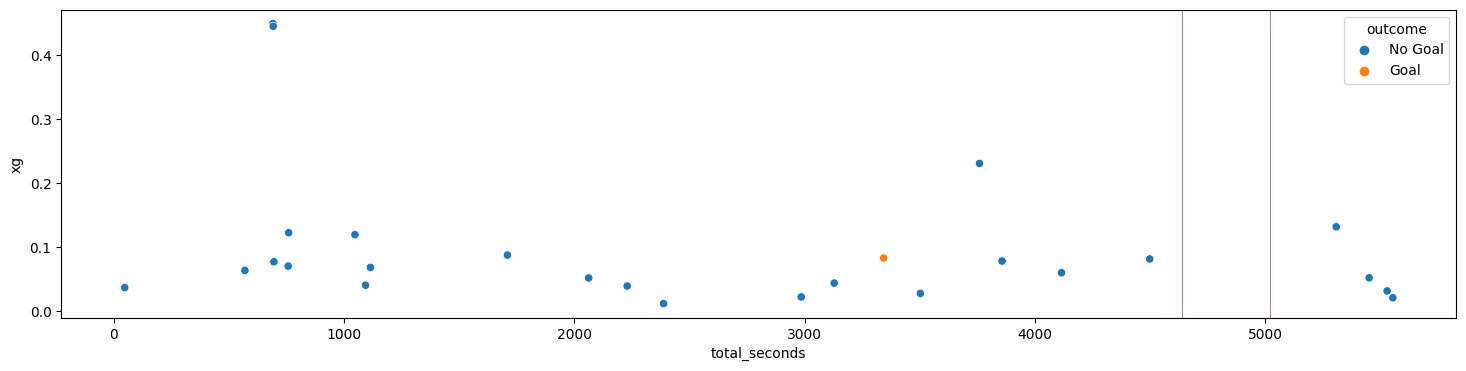

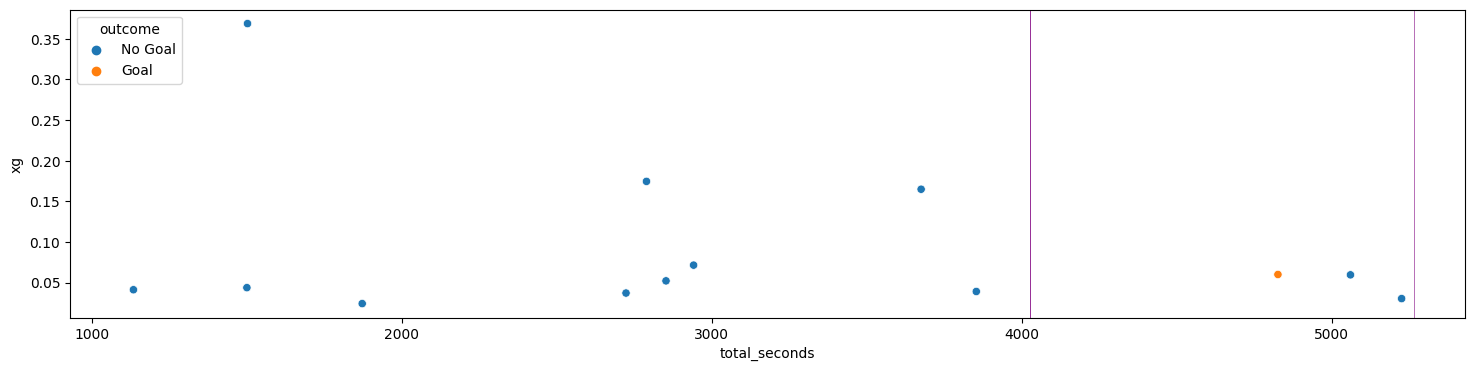

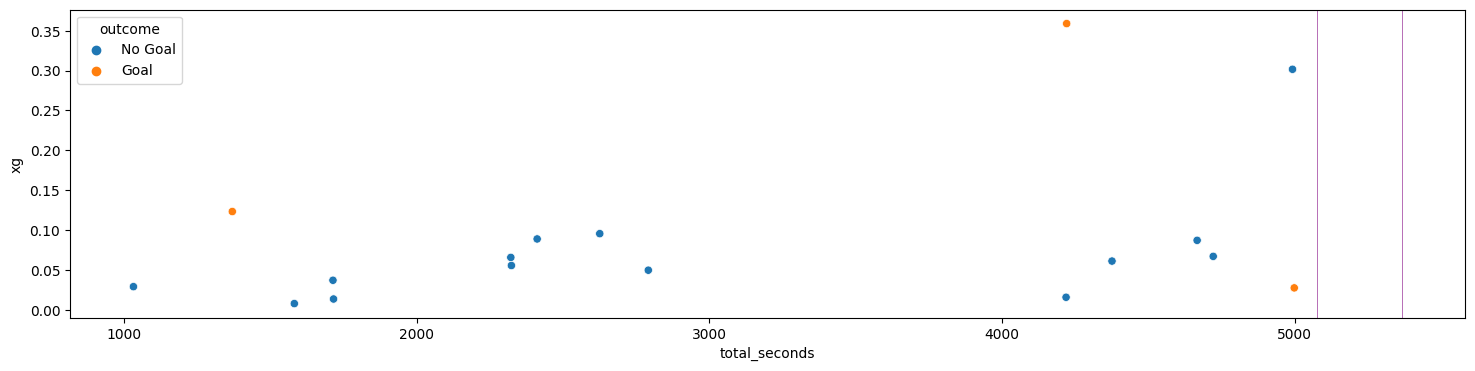

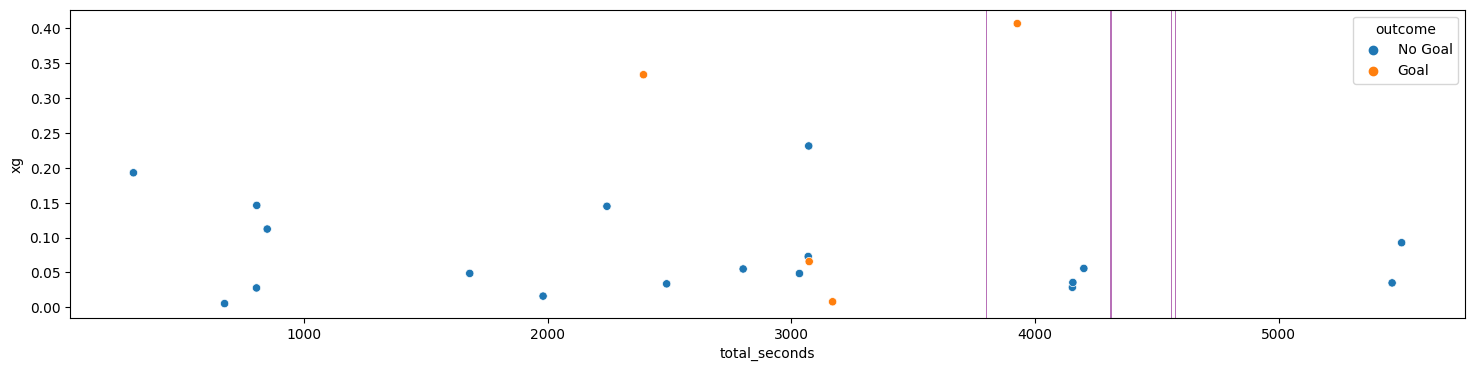

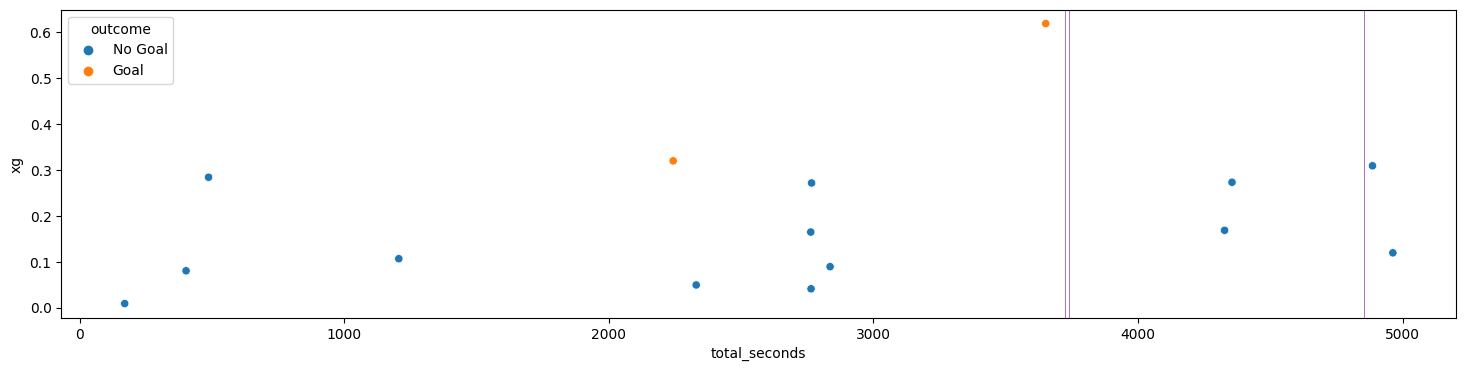

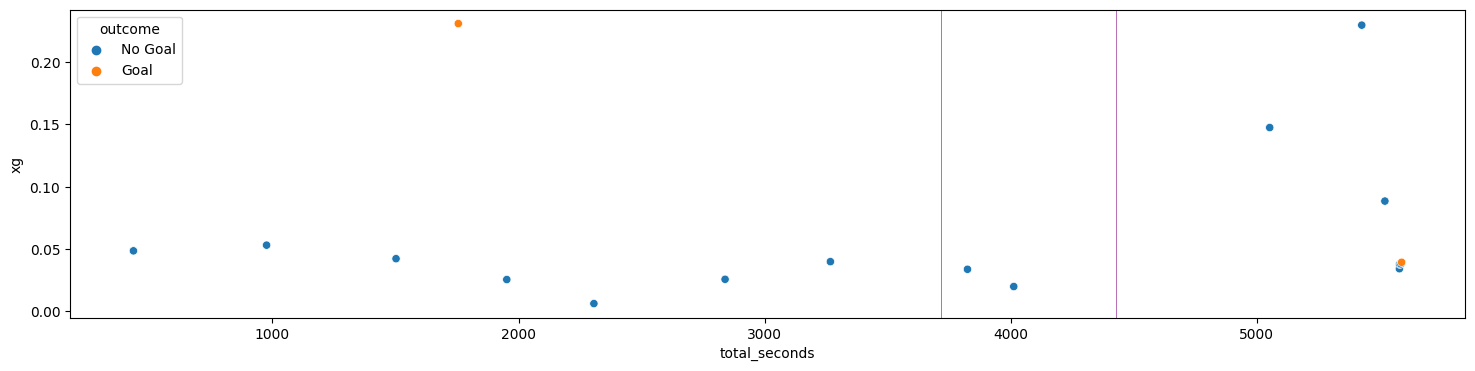

In [20]:
# Plot xg by time (seconds) and mark substitution for all matches Gareth Taylor coached
for match in manager_match_dict['Gareth Taylor']:
    plt.subplots(figsize=(18,4))
    xg_df = get_xg(match, 'Manchester City WFC')
    sub_time = get_sub(match, 'Manchester City WFC')
    sns.scatterplot(data = xg_df, x = 'total_seconds', y = 'xg', hue = 'outcome')
    for t in sub_time:
        plt.axvline(x = t, color = 'purple', linewidth=0.4)

In [21]:
def get_x(match_id, team):
    '''
    Generate dataframe containing time and location x value for selected match and selected team
    
    Arg: match_id(int)
         team(str)
    Return: dataframe
    '''
    events = get_event(match_id)
    events_x = [{'minute': e['minute'], 'second': e['second'], 'x':e['location'][0], 'team':e['team']['name']} 
                for e in events if 'location' in e]
    df = pd.DataFrame(events_x)
    df['x'] = df.apply(lambda row: row['x'] if row['team'] == team else 120-row['x'], axis = 1)
    df['total_seconds'] = df.apply(lambda row: row['minute']*60 + row['second'], axis = 1)
    return df

In [39]:
def transform(df):
    '''
    Transform x value dataframe to apply CausalImpact module
    
    Arg: dataframe
    Return: dataframe
    '''
    dummy_df = pd.DataFrame({'total_seconds': range(0, df['total_seconds'].max())})
    df_merge = pd.merge(dummy_df, df, on = 'total_seconds', how = 'outer')
    df_merge['x'] = df_merge['x'].interpolate()
    df_merge = df_merge.groupby('total_seconds')['x'].mean().reset_index()
    df_merge = df_merge[['x']]

    return df_merge

In [40]:
df_new = transform(test_df)

In [41]:
df_new

,x
0,61.000000
1,38.300000
2,39.600000
3,40.900000
4,55.966667
...,...
5766,5.303704
5767,5.477778
5768,5.651852
5769,5.825926


In [31]:
sub_time = get_sub(3764230, 'Tottenham Hotspur Women')

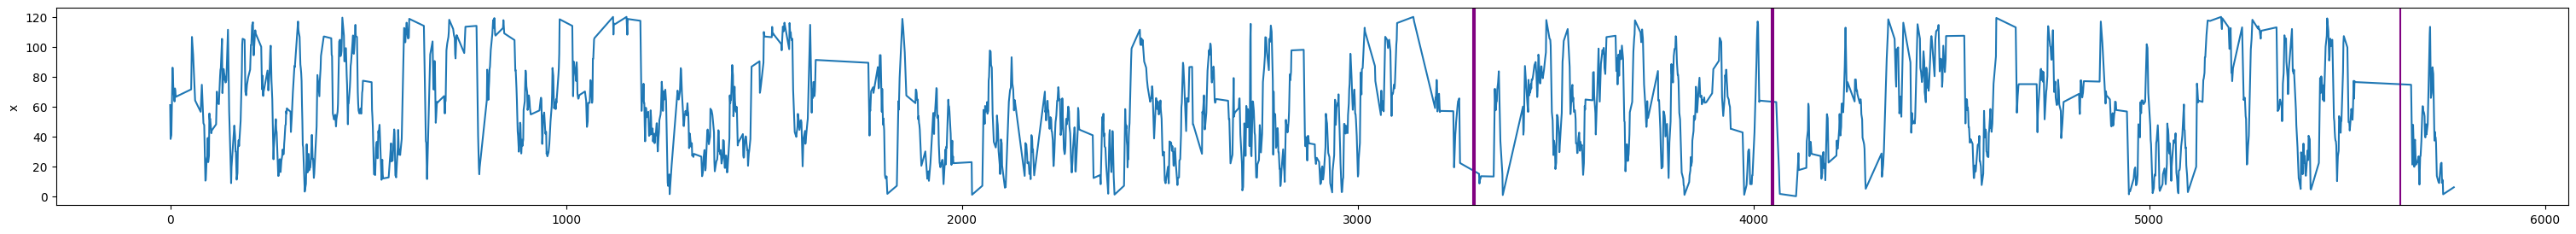

In [32]:
plt.figure(figsize=(38, 3))
sns.lineplot(x = df_new.index, y = df_new['x'])
for t in sub_time:
    plt.axvline(x = t, color = 'purple')

In [101]:
sub_datetime = [datetime(1970,1,1) + timedelta(seconds = t) for t in sub_time]
sub_datetime = [t.strftime('%H:%M:%S') for t in sub_datetime]

In [118]:
sub_time

[3291, 3296, 4046, 4050, 5635]

In [42]:
impact = CausalImpact(data = df_new, pre_period = [0, 3291], post_period = [3292, 5770])

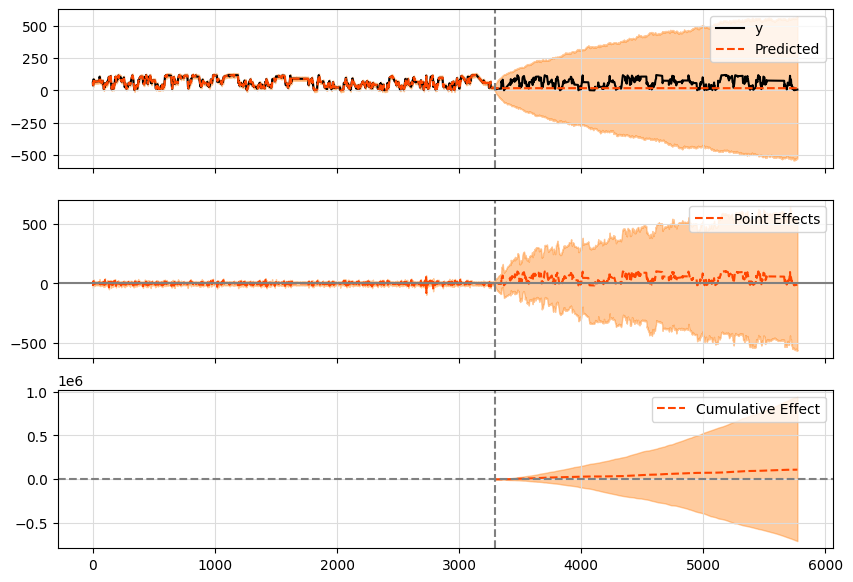

In [43]:
impact.plot()

In [44]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    61.59              152693.79
Prediction (s.d.)         17.44 (158.54)     43245.96 (393026.68)
95% CI                    [-275.84, 345.64]  [-683805.03, 856831.58]

Absolute effect (s.d.)    44.15 (158.54)     109447.83 (393026.68)
95% CI                    [-284.04, 337.43]  [-704137.78, 836498.82]

Relative effect (s.d.)    253.08% (908.82%)  253.08% (908.82%)
95% CI                    [-1628.22%, 1934.28%][-1628.22%, 1934.28%]

Posterior tail-area probability p: 0.38
Posterior prob. of a causal effect: 62.14%

For more details run the command: print(impact.summary('report'))


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/win-64/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarch/current_repodata.json HTTP/1.1" 304 0
DEBUG:urll

Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed
